In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using Zygote, Lux, LuxCUDA, ComponentArrays, Plots, QuadGK, Interpolations, Optimisers, NNlib, JLD2
using Random: Xoshiro
using MLUtils: DataLoader

In [3]:
using PhasorNetworks

Precompiling EnzymeBFloat16sExt
        Info Given EnzymeBFloat16sExt was explicitly requested, output will be shown live 
ERROR: LoadError: UndefVarError: `typetree_inner` not defined
Stacktrace:
 [1] getproperty(x::Module, f::Symbol)
   @ Base ./Base.jl:31
 [2] top-level scope
   @ ~/.julia/packages/Enzyme/BkuKz/ext/EnzymeBFloat16sExt.jl:6
 [3] include
   @ ./Base.jl:495 [inlined]
 [4] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::Nothing)
   @ Base ./loading.jl:2222
 [5] top-level scope
   @ stdin:3
in expression starting at /Users/wilkie/.julia/packages/Enzyme/BkuKz/ext/EnzymeBFloat16sExt.jl:1
in expression starting at stdin:3
  ✗ Enzyme → EnzymeBFloat16sExt
  0 dependencies successfully precompiled in 2 seconds. 40 already precompiled.
[ Info: Precompiling EnzymeBFloat16sExt [81044f38-2e40-5cb6-802a-fb09abd5af23]
ERROR: LoadErr

# Load the dataset

In [4]:
include("pixel_data.jl")

interpolate_roc (generic function with 1 method)

In [5]:
using Base: @kwdef

In [6]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 128    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [7]:
args = Args(batchsize = 128)

Args(0.0003, 128, 10, false)

In [8]:
data_dir = "pixel_data/"

"pixel_data/"

In [9]:
file_pairs = get_dataset(data_dir)

10-element Vector{Tuple{String, String}}:
 ("pixel_data/labels/labels_d17301.parquet", "pixel_data/recon3D/recon3D_d17301.parquet")
 ("pixel_data/labels/labels_d17302.parquet", "pixel_data/recon3D/recon3D_d17302.parquet")
 ("pixel_data/labels/labels_d17303.parquet", "pixel_data/recon3D/recon3D_d17303.parquet")
 ("pixel_data/labels/labels_d17304.parquet", "pixel_data/recon3D/recon3D_d17304.parquet")
 ("pixel_data/labels/labels_d17305.parquet", "pixel_data/recon3D/recon3D_d17305.parquet")
 ("pixel_data/labels/labels_d17306.parquet", "pixel_data/recon3D/recon3D_d17306.parquet")
 ("pixel_data/labels/labels_d17307.parquet", "pixel_data/recon3D/recon3D_d17307.parquet")
 ("pixel_data/labels/labels_d17308.parquet", "pixel_data/recon3D/recon3D_d17308.parquet")
 ("pixel_data/labels/labels_d17309.parquet", "pixel_data/recon3D/recon3D_d17309.parquet")
 ("pixel_data/labels/labels_d17310.parquet", "pixel_data/recon3D/recon3D_d17310.parquet")

In [10]:
q, ylocal, pt = get_samples(file_pairs[1:2])

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [11]:
q_test, ylocal_test, pt_test = get_samples(file_pairs[3:3]);

In [12]:
q |> size

(20, 13, 21, 99991)

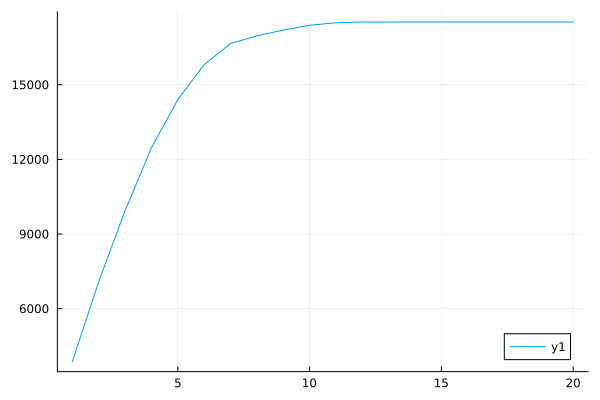

In [13]:
plot(sum(q[:,:,:,128], dims=(2,3)) |> vec)

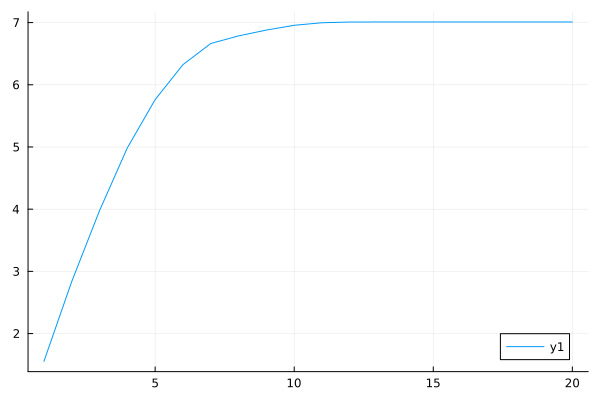

In [14]:
plot(sum(scale_charge(q[:,:,:,128]), dims=(2,3)) |> vec)

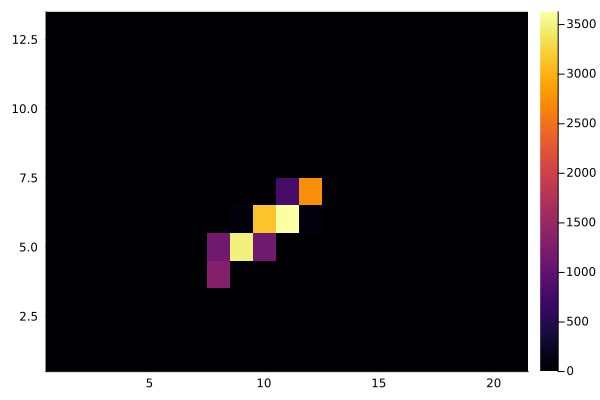

In [15]:
heatmap(q[12,:,:,128])

In [16]:
ylocal |> size

(99991,)

In [17]:
pt |> size

(99991,)

In [18]:
train_loader = DataLoader((q, ylocal, pt), batchsize=args.batchsize)

782-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [19]:
test_loader = DataLoader((q_test, ylocal_test, pt_test), batchsize=args.batchsize)

391-element DataLoader(::Tuple{Array{Float64, 4}, Vector{Float64}, Vector{Float64}}, batchsize=128)
  with first element:
  (20×13×21×128 Array{Float64, 4}, 128-element Vector{Float64}, 128-element Vector{Float64},)

In [20]:
x, xl, y = first(train_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [21]:
x |> size

(20, 13, 21, 128)

In [22]:
n_px = size(x, 2) 
n_in = n_px + 1

14

# Set up the model

In [63]:
function process_inputs(x, y_local)
    x = scale_charge(x[end,:,:,:])
    x = sum(x, dims=(2))
    n_batch = size(x, 3)
    x = reshape(x, (n_px, n_batch))
    y_local = reshape(y_local, (1, n_batch))

    x = cat(x, y_local, dims = 1)
    return x
end

process_inputs (generic function with 1 method)

In [64]:
process_inputs(x, xl)

14×128 Matrix{Float64}:
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.252     0.0004    0.0         0.0      0.03       0.0
  0.3008    1.4032    0.3624    0.6752      0.0      2.9176     0.5328
  0.8116    1.6196    0.89      2.6088      0.0      4.998      2.304
  1.0256    1.5404    1.2096    2.2608   …  1.1748   2.0668     2.768
  0.9528    0.6404    1.2876    3.8688      2.752    0.0        1.4048
  0.6928    0.0       0.464     0.0         0.0132   0.0        0.0
  0.4444    0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0      …  0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
  0.0       0.0       0.0       0.0         0.0      0.0        0.0
 -6.94104  -4.33669  -7.79379  -2.67448     3.28174  0.134332  -1.43261

In [65]:
model = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    PhasorDense(n_in => 128),
    PhasorDense(128 => 3) 
)

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction{:direct_call}(var"#52#53"()),
    layer_3 = PhasorDense((14, 128)),   # 1_920 parameters
    layer_4 = PhasorDense((128, 3)),    # 387 parameters
)         # Total: 2_335 parameters,
          #        plus 29 states.

In [66]:
model_front = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    PhasorDense(n_in => 128),
    #PhasorDense(128 => 3) 
)

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction{:direct_call}(var"#54#55"()),
    layer_3 = PhasorDense((14, 128)),   # 1_920 parameters
)         # Total: 1_948 parameters,
          #        plus 29 states.

In [67]:
rng = Xoshiro(42)
ps, st = Lux.setup(rng, model)

((layer_1 = (scale = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.012532993 0.13751148 … 0.005174529 -0.1467415; -0.10304676 0.08072104 … 0.08704694 -0.1512706; … ; 0.11642004 -0.1825578 … -0.119460106 -0.06416814; 0.056921583 -0.09566052 … 0.085579105 -0.20602593], bias = ComplexF32[1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im  …  1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im, 1.0f0 + 0.0f0im]), layer_4 = (weight = Float32[0.10452084 0.07265444 … -0.038100667 0.05980781; -0.022380695 -0.15790255 … 0.04576584 0.037232745; 0.05314552 -0.14570683 … -0.1345809 0.32224092], bias = ComplexF32

In [68]:
y_naive, _ = model(process_inputs(x, xl), ps, st)

([-0.74517625528442 -0.5820031036872476 … -0.5588782808365526 -0.6626814552669679; 0.7629462916768684 -0.8988422833294372 … -0.9690701881641076 0.9741564845616076; -0.0005357789548063084 0.017626278487743608 … 0.024557476673182338 0.0528777644418035], (layer_1 = (running_mean = [0.0, 0.0007275000108405948, 0.009984687648783437, 0.06526031347245444, 0.18840875280750918, 0.2391881285641809, 0.20015500298254196, 0.05920625088224188, 0.008364062624634244, 0.0, 0.0, 0.0, 0.0, 0.07180550185123537], running_var = [0.8999999761581421, 0.9006013163245831, 0.9166694592716942, 1.0714547488537651, 1.6086467878359128, 1.8480822565809447, 1.6426738276027972, 1.0505631442442278, 0.9130537317768708, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [69]:
y_naive |> size

(3, 128)

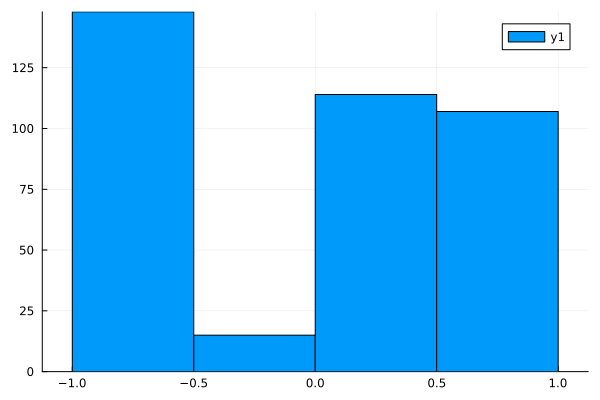

In [70]:
histogram(y_naive |> vec)

In [71]:
using Statistics: std, median, mean

In [72]:
using OneHotArrays

In [73]:
function get_truth(pt, threshold::Real = 0.2)
    return 1 .* (pt .> threshold) .+ 2 .* (pt .< -threshold)
end

get_truth (generic function with 2 methods)

In [74]:
function momentum_to_label(pt, threshold::Real = 0.2)
    y = onehotbatch(get_truth(pt, threshold), (0, 1, 2))
    return y
end

momentum_to_label (generic function with 2 methods)

In [75]:
labels = momentum_to_label(pt)

3×99991 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  1  ⋅  1  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1
 1  1  ⋅  1  1  ⋅  1  1  ⋅  ⋅  1  1  ⋅     1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅
 ⋅  ⋅  1  ⋅  ⋅  1  ⋅  ⋅  1  1  ⋅  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  1  1  1  1  ⋅  ⋅  ⋅

In [76]:
function loss(x, xl, y, model, ps, st, threshold)
    y_pred, st = model(process_inputs(x, xl), ps, st)
    y = momentum_to_label(y, threshold)
    loss = quadrature_loss(y_pred, y) |> mean
    return loss, st
end

loss (generic function with 1 method)

In [77]:
l0, st0 = @time loss(x, xl, y, model, ps, st, 0.2)

  0.007997 seconds (7.56 k allocations: 2.413 MiB, 89.59% compilation time)


(1.256037613446628, (layer_1 = (running_mean = [0.0, 0.0007275000108405948, 0.009984687648783437, 0.06526031347245444, 0.18840875280750918, 0.2391881285641809, 0.20015500298254196, 0.05920625088224188, 0.008364062624634244, 0.0, 0.0, 0.0, 0.0, 0.07180550185123537], running_var = [0.8999999761581421, 0.9006013163245831, 0.9166694592716942, 1.0714547488537651, 1.6086467878359128, 1.8480822565809447, 1.6426738276027972, 1.0505631442442278, 0.9130537317768708, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 0.8999999761581421, 2.9173396135808085], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [78]:
l0

1.256037613446628

In [79]:
function train(model, ps, st, train_loader, threshold::Real = 0.2; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    device = cpu

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt_state = Optimisers.setup(Adam(3e-4), ps)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        #epoch_losses = []
        for (x, xl, y) in train_loader
            (loss_val, st), gs = withgradient(p -> loss(x, xl, y, model, p, st, threshold), ps)
            opt_state, ps = Optimisers.update(opt_state, ps, gs[1]) ## update parameters
            append!(losses, loss_val)
        end
        
    end

    return losses, ps, st
end

train (generic function with 2 methods)

In [80]:
@time loss_history, pst, stt = train(model, ps, st, train_loader, 0.2, epochs = 10)

[ Info: Constructing model and starting training


 34.558976 seconds (10.44 M allocations: 133.434 GiB, 18.43% gc time, 6.68% compilation time)


(Any[1.256037613446628, 1.1788250310001902, 1.1333813564159083, 1.0865125179076907, 0.994924091749093, 0.9158776527886883, 0.9122332983006921, 0.8210545062203808, 0.7967392839632855, 0.8164478863202368  …  0.16115578671766995, 0.16315488589972135, 0.15072402247058997, 0.1584806040932006, 0.16493081189207734, 0.1789752957881819, 0.19695063360971604, 0.18396571551368057, 0.1934567453207611, 0.26805676453252614], (layer_1 = (scale = Float32[0.70195687, 0.98452, 0.93526834, 0.8544426, 1.0598541, 0.828761, 1.0817488, 0.98541, 0.9945907, 0.6670145, 0.5249866, 0.8084054, 0.54577255, 0.33123395], bias = Float32[-0.15099551, -0.027765948, 0.16778935, 0.4040146, 0.16884889, 0.38668466, -0.0263089, 0.2820829, 0.011799936, -0.1444711, -0.05795451, -0.0013061733, -0.10369904, 0.17921323]), layer_2 = NamedTuple(), layer_3 = (weight = Float32[-0.029015422 0.097359166 … -0.04040092 -0.11847279; -0.13258184 0.019788489 … 0.09127946 -0.07247774; … ; 0.12507679 -0.22224443 … -0.05558531 -0.070182785; 0.0

In [81]:
sttf = Lux.testmode(stt)

(layer_1 = (running_mean = [0.03594616161788155, 0.04065939470148213, 0.24366647968169539, 1.0156471076493, 2.3585091340869972, 2.6301745158212135, 1.8952205505395425, 0.6306864595118056, 0.0972046012689178, 0.019270684388906934, 0.011654752692122225, 0.005198475128358864, 0.006348779794351645, 0.15291454619067543], running_var = [0.17845984020323682, 0.10809495006040458, 0.5665038009449749, 2.9413779193354155, 9.074032896510717, 7.835651333226607, 7.166495019956767, 1.96909766899202, 0.2683655759503202, 0.06505530708282091, 0.03435994576714579, 0.008197384732891742, 0.03335087394257168, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple())

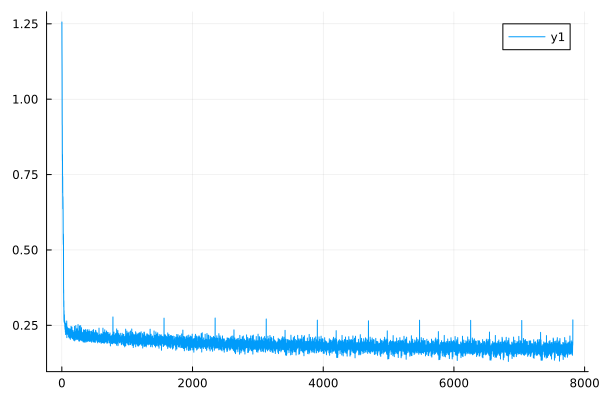

In [82]:
plot(loss_history)

In [83]:
loss(x, xl, y, model, pst, stt, 0.2)[1]

0.17739153221319462

# Load a Trained version

In [1]:
#trained = load("trained_nns/pmlp_id_43_epoch_100.jld2")

In [85]:
#pst = trained["params"]

In [86]:
#sttf = Lux.testmode(trained["state"])

In [87]:
#loss(x, xl, y, model, pst, sttf, 0.2)

In [88]:
psf = (layer_1 = pst.layer_1, layer_2 = pst.layer_2, layer_3 = pst.layer_3, )
stf = (layer_1 = stt.layer_1, layer_2 = stt.layer_2, layer_3 = stt.layer_3, )

(layer_1 = (running_mean = [0.03594616161788155, 0.04065939470148213, 0.24366647968169539, 1.0156471076493, 2.3585091340869972, 2.6301745158212135, 1.8952205505395425, 0.6306864595118056, 0.0972046012689178, 0.019270684388906934, 0.011654752692122225, 0.005198475128358864, 0.006348779794351645, 0.15291454619067543], running_var = [0.17845984020323682, 0.10809495006040458, 0.5665038009449749, 2.9413779193354155, 9.074032896510717, 7.835651333226607, 7.166495019956767, 1.96909766899202, 0.2683655759503202, 0.06505530708282091, 0.03435994576714579, 0.008197384732891742, 0.03335087394257168, 19.956601029145197], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple())

In [89]:
ytf = model_front(process_inputs(x, xl), psf, stf)[1];

In [90]:
size(ytf)

(128, 128)

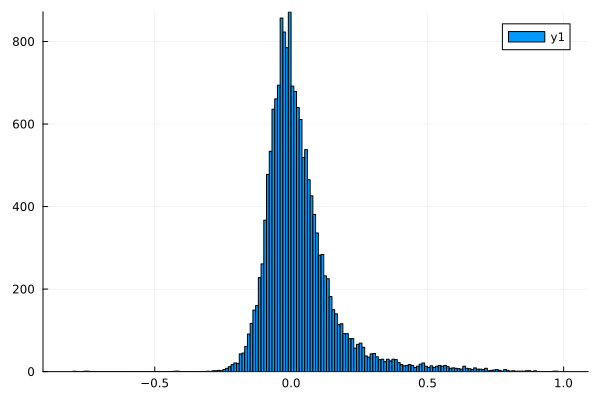

In [91]:
histogram(ytf |> vec)

In [92]:
yt, _ = model(process_inputs(x, xl), pst, sttf)

([0.014443128314726397 0.017576384376449213 … 0.012913758108121636 0.012081790553707134; 0.4489746982327246 0.2742330602414453 … 0.193675857640253 0.1981860129294226; 0.05951300303108706 0.21112793396594579 … 0.33653245345861427 0.20850442757707038], (layer_1 = (running_mean = [0.03594616161788155, 0.04065939470148213, 0.24366647968169539, 1.0156471076493, 2.3585091340869972, 2.6301745158212135, 1.8952205505395425, 0.6306864595118056, 0.0972046012689178, 0.019270684388906934, 0.011654752692122225, 0.005198475128358864, 0.006348779794351645, 0.15291454619067543], running_var = [0.17845984020323682, 0.10809495006040458, 0.5665038009449749, 2.9413779193354155, 9.074032896510717, 7.835651333226607, 7.166495019956767, 1.96909766899202, 0.2683655759503202, 0.06505530708282091, 0.03435994576714579, 0.008197384732891742, 0.03335087394257168, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

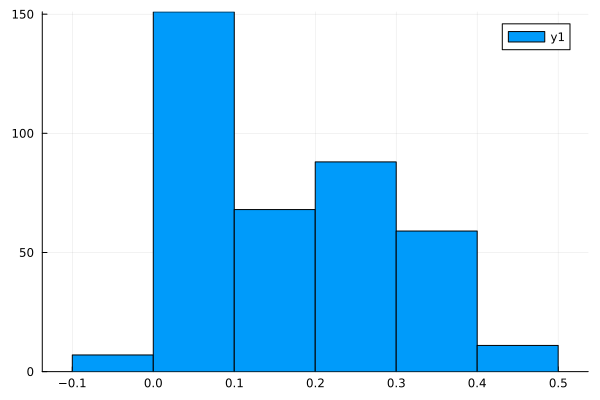

In [93]:
histogram(yt |> vec)

# Calculate the Test Loss

In [94]:
xts, xlts, yts = first(test_loader)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 

In [95]:
function accuracy(x, xl, y, model, ps, st, threshold::Real)
    y_truth = get_truth(y, threshold)
    y_pred, _ = model(process_inputs(x, xl), ps, st)
    #predict & correct for zero indexing
    y_labels = predict_quadrature(y_pred) .- 1
    right = sum(y_truth .== y_labels)
    return right
end

accuracy (generic function with 1 method)

In [96]:
yth, _ = model(process_inputs(q_test[:,:,:,1:10000], ylocal_test[1:10000]), pst, stt)

([0.01805667818882596 0.013610738852194909 … 0.018326624565259523 0.0176054096578265; 0.03247196715718518 0.007376282578656554 … 0.04361797945835623 0.2944348435445903; 0.3929602440388748 0.37636049290513995 … 0.3495322206389168 0.1461600763167671], (layer_1 = (running_mean = [0.03463138063304232, 0.03982174631004372, 0.24518697428981276, 1.0233261014973147, 2.359646587578462, 2.634903269920575, 1.89858549437425, 0.631662060678222, 0.09877864299278896, 0.019815863527406687, 0.011903677166115246, 0.005394331502246492, 0.00621740167105251, 0.1393648519317953], running_var = [0.17184187351968375, 0.1045715148436045, 0.5713877119339248, 2.990126611337082, 9.045938320572654, 7.853287653827764, 7.229449784592336, 1.967455892285519, 0.2718856746022663, 0.06821195170421673, 0.036241541131131934, 0.008975805015312652, 0.03124548247146173, 20.015114414752453], training = Val{true}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple()))

In [97]:
accuracy(q_test[:,:,:,1:10000], ylocal_test[1:10000], pt_test[1:10000], model, pst, stt, 0.2)

6915

In [98]:
using LinearAlgebra: diag

In [99]:
roc = tpr_fpr(yth, pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

In [100]:
roc_fn = linear_interpolation(average_duplicate_knots(roc[2], roc[1])...)

20-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0005
 0.0059
 0.0314
 0.1032
 0.2392
 0.4262
 0.6142
 0.7637
 0.8591
 0.9079
 0.9302
 0.994
 0.997
 0.9984
 0.9992
 0.9999
 1.0
 1.0

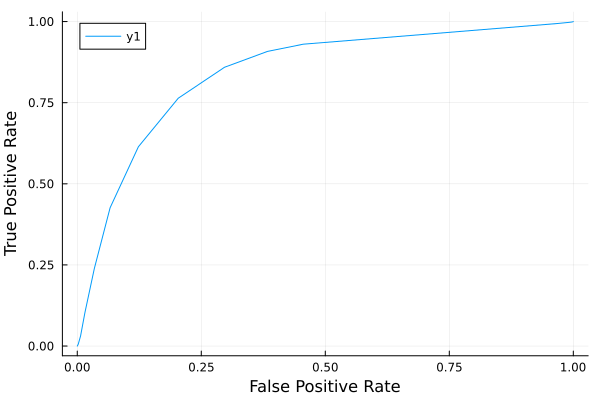

In [101]:
plot(roc[2], roc[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [102]:
auc, _ = quadgk(roc_fn, 0.0, 1.0)

(0.8428981217645163, 1.1885623541992759e-8)

# Build a Spiking Version

In [103]:
sa = SpikingArgs()
repeats = 20

20

In [60]:
model_spk = Chain(
    BatchNorm(n_in),
    x -> tanh.(x),
    MakeSpiking(sa, repeats),
    PhasorDense(n_in => 128),
    PhasorDense(128 => 3) 
)

Chain(
    layer_1 = BatchNorm(14, affine=true, track_stats=true),  # 28 parameters, plus 29
    layer_2 = WrappedFunction{:direct_call}(var"#44#45"()),
    layer_3 = MakeSpiking(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 20, (0.0, 20.0), 0.0),
    layer_4 = PhasorDense((14, 128)),   # 1_920 parameters
    layer_5 = PhasorDense((128, 3)),    # 387 parameters
)         # Total: 2_335 parameters,
          #        plus 29 states.

In [61]:
function convert_pmlp_params(pmlp_ps)
    # Add a dummy layer of params for the make_spiking layer
    spk_ps = (layer_1 = pmlp_ps.layer_1, 
            layer_2 = pmlp_ps.layer_2,
            layer_3 = NamedTuple(),
            layer_4 = pmlp_ps.layer_3,
            layer_5 = pmlp_ps.layer_4)
    return spk_ps
end      

convert_pmlp_params (generic function with 1 method)

In [62]:
pst_spk = convert_pmlp_params(pst)
sttf_spk = convert_pmlp_params(sttf)

(layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple())

In [63]:
yth_spk, _ = model_spk(process_inputs(q_test[:,:,:,1:10000], ylocal_test[1:10000]), pst_spk, sttf_spk)

(SpikingCall(Spike Train: (3, 10000) with 600000 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 20.0)), (layer_1 = (running_mean = [0.5757944121368425, 0.6846214445057881, 3.877447210797926, 16.457718797941705, 40.50550733079511, 46.45902297891875, 34.455593553787885, 11.694720261830742, 1.4321486865495832, 0.27754491012521154, 0.20938791166720094, 0.09354000307185677, 0.11033681559878909, 0.15291454619067543], running_var = [45.4440043349743, 30.597847176643445, 142.5825230347542, 785.3730588946706, 2787.8957479624682, 2453.057413839121, 2345.648527495587, 722.0711161220706, 91.57263090145504, 19.209888472669824, 10.95922934152389, 2.537559208572711, 11.005162970582472, 19.956601029145197], training = Val{false}()), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple()))

In [64]:
yth_spk2 = train_to_phase(yth_spk);

In [65]:
size(yth_spk2)

(20, 3, 10000)

In [66]:
size(yth)

(3, 10000)

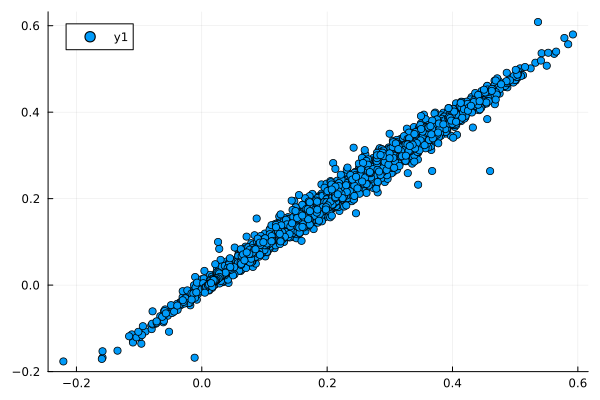

In [67]:
scatter(vec(yth[:,1:1000]), vec(yth_spk2[end-1,:,1:1000]))

In [68]:
roc_spk = tpr_fpr(yth_spk2[end-1,:,:], pt_test[1:10000])

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

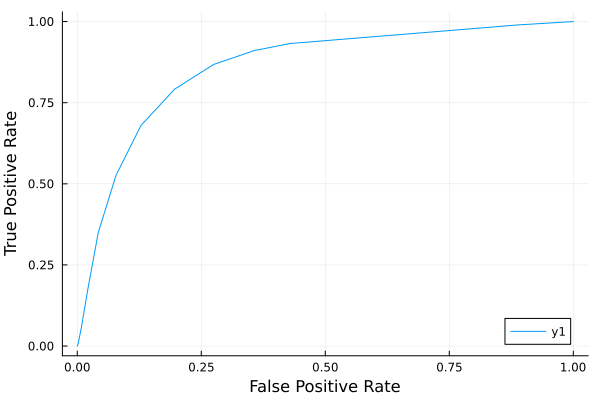

In [69]:
plot(roc_spk[2], roc_spk[1])
xlabel!("False Positive Rate")
ylabel!("True Positive Rate")

In [70]:
roc_spk_fn = linear_interpolation(average_duplicate_knots(roc_spk[2], roc_spk[1])...)

21-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Throw()) with element type Float64:
 0.0
 0.0
 0.0003
 0.0014
 0.0091
 0.0547
 0.1707
 0.35
 0.5259
 0.6799
 0.7917
 0.8677
 0.9104
 0.9323
 0.9896
 0.9984
 0.9994
 0.9999
 1.0
 1.0
 1.0

In [72]:
quadgk(roc_spk_fn, 0.0, 1.0)

(0.8602563581517786, 1.1983057030231774e-8)